## XGBoost (Multi-output) Baseline for Switching Waveform Transients

- Balanced FAST sampling for quick iteration
- 70/15/15 split (via 70/30 then halved)
- Scale outputs ONLY (inputs left in physical units)
- Metrics (R2, RMSE, MAE) per target + overall
- Plots: Val vs Test R² bars, Test scatter, Residual histograms
- Mean XGB feature importance across outputs
- SHAP 4-grid: mean|SHAP| bar + top-3 dependence plots

[INFO] Using 86335 rows (of 431675)
[INFO] Train time: 50.48s

=== Validation (per target) ===
                  Target     R2       RMSE        MAE
voltage_rise_time_pulse1 0.9774 6.0421e-10 3.1452e-10
voltage_rise_time_pulse2 0.8980 1.4115e-09 7.4237e-10
voltage_fall_time_pulse1 0.9997 1.1783e-10 7.2372e-11
voltage_fall_time_pulse2 0.9997 1.1613e-10 7.1213e-11
current_rise_time_pulse1 0.9161 1.3605e-08 7.1063e-09
current_rise_time_pulse2 0.9040 8.2731e-09 4.2419e-09
current_fall_time_pulse1 0.9995 2.7539e-10 1.3511e-10
current_fall_time_pulse2 0.9997 2.2671e-10 1.3524e-10
       overshoot_pulse_1 0.9832 1.7492e+00 1.3679e+00
       overshoot_pulse_2 0.9410 6.4581e+00 4.9569e+00
      undershoot_pulse_1 0.9877 1.4921e+00 9.1608e-01
      undershoot_pulse_2 0.9880 1.4736e+00 9.0354e-01
   ringing_frequency_MHz 0.9990 9.9422e-01 7.0584e-01
R2_avg          0.9687
RMSE_avg    1.9642e+00
MAE_avg     6.8079e-01
dtype: object

=== Test (per target) ===
                  Target     R2       R

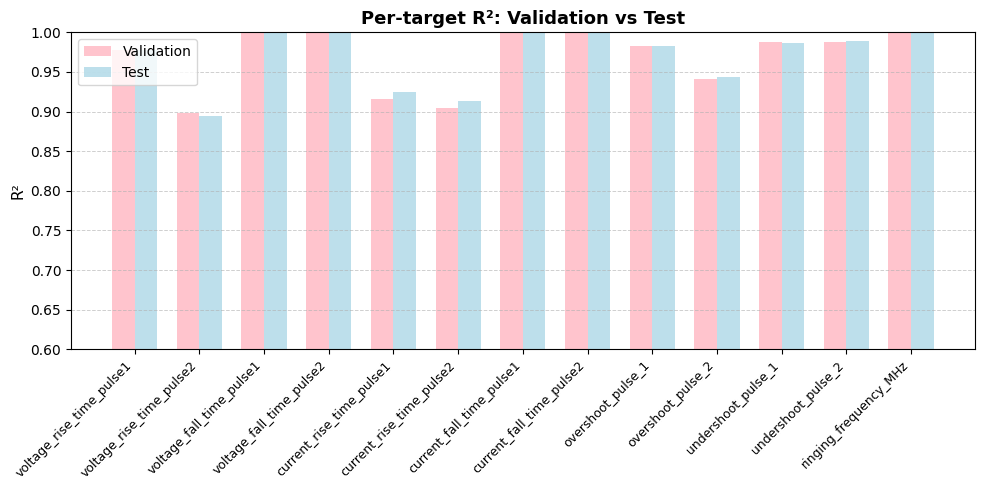

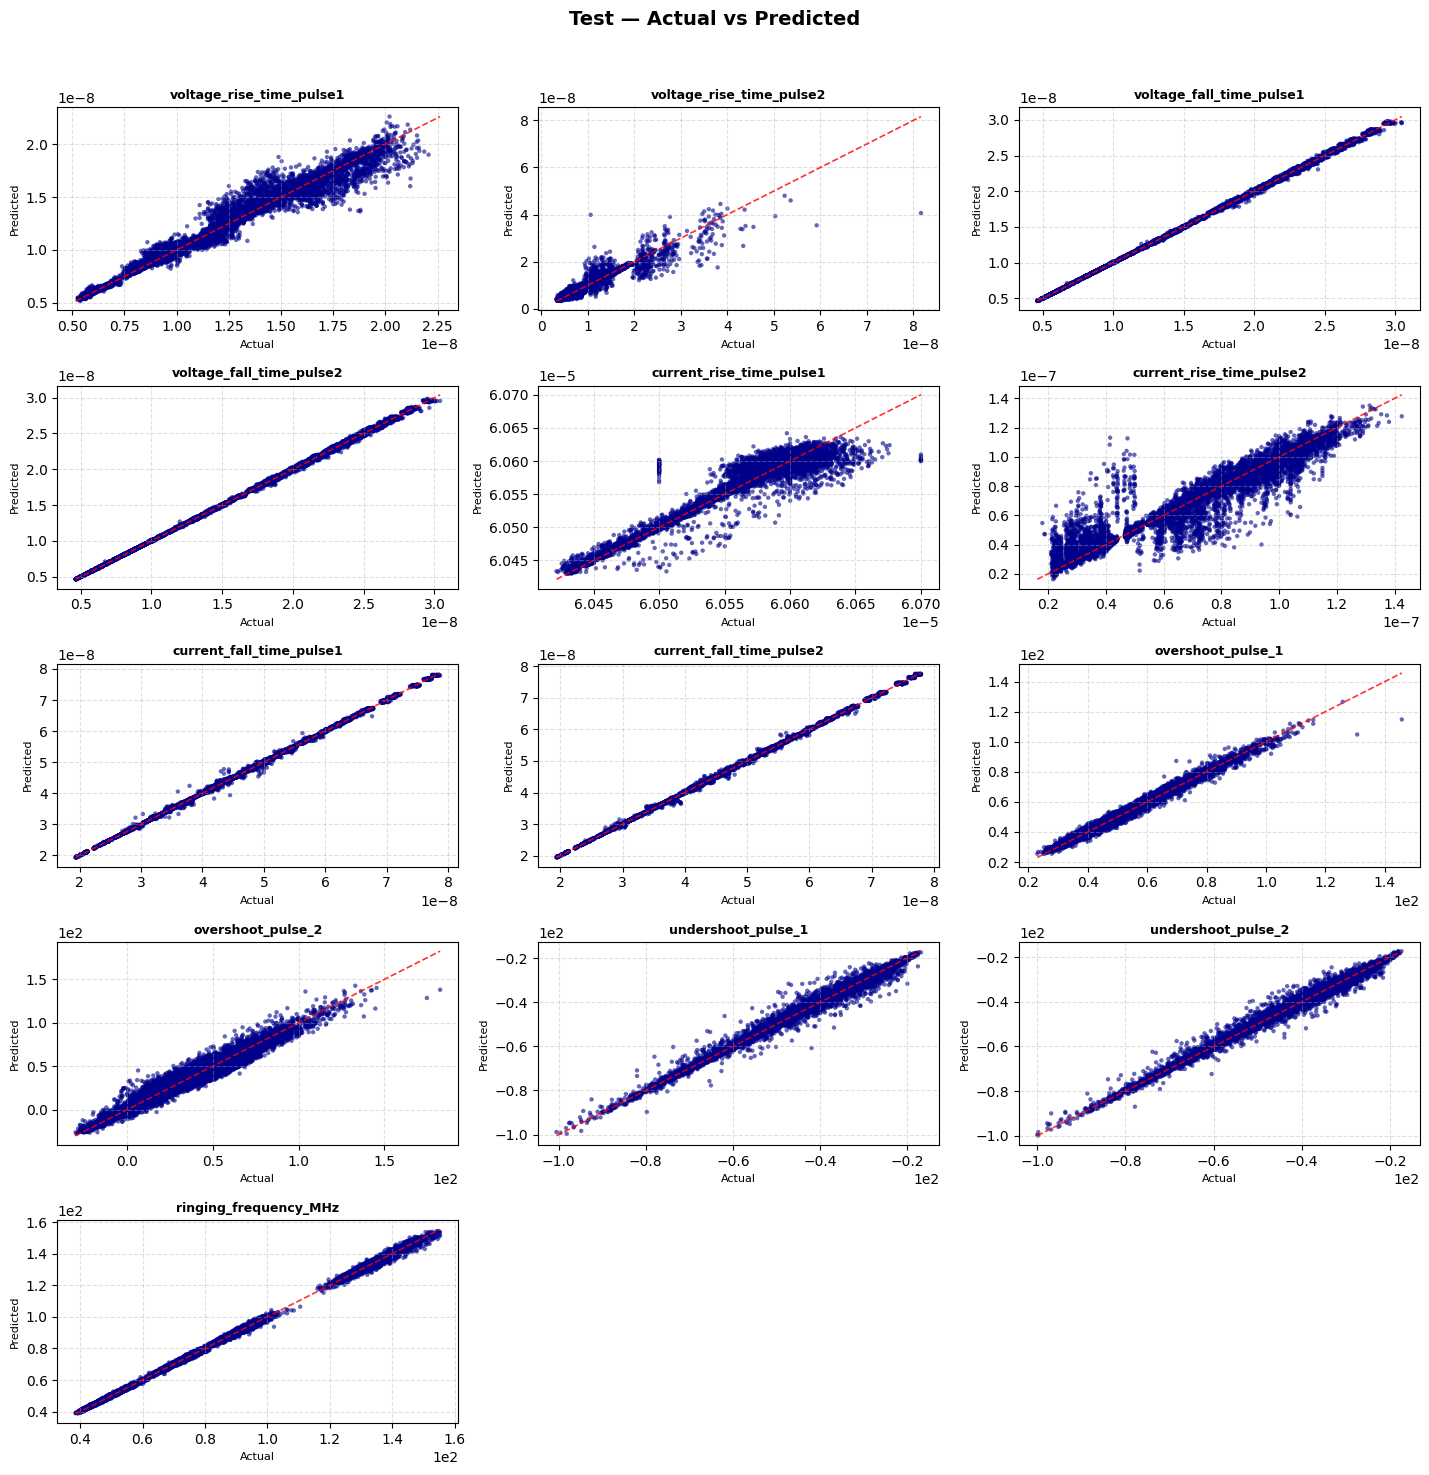

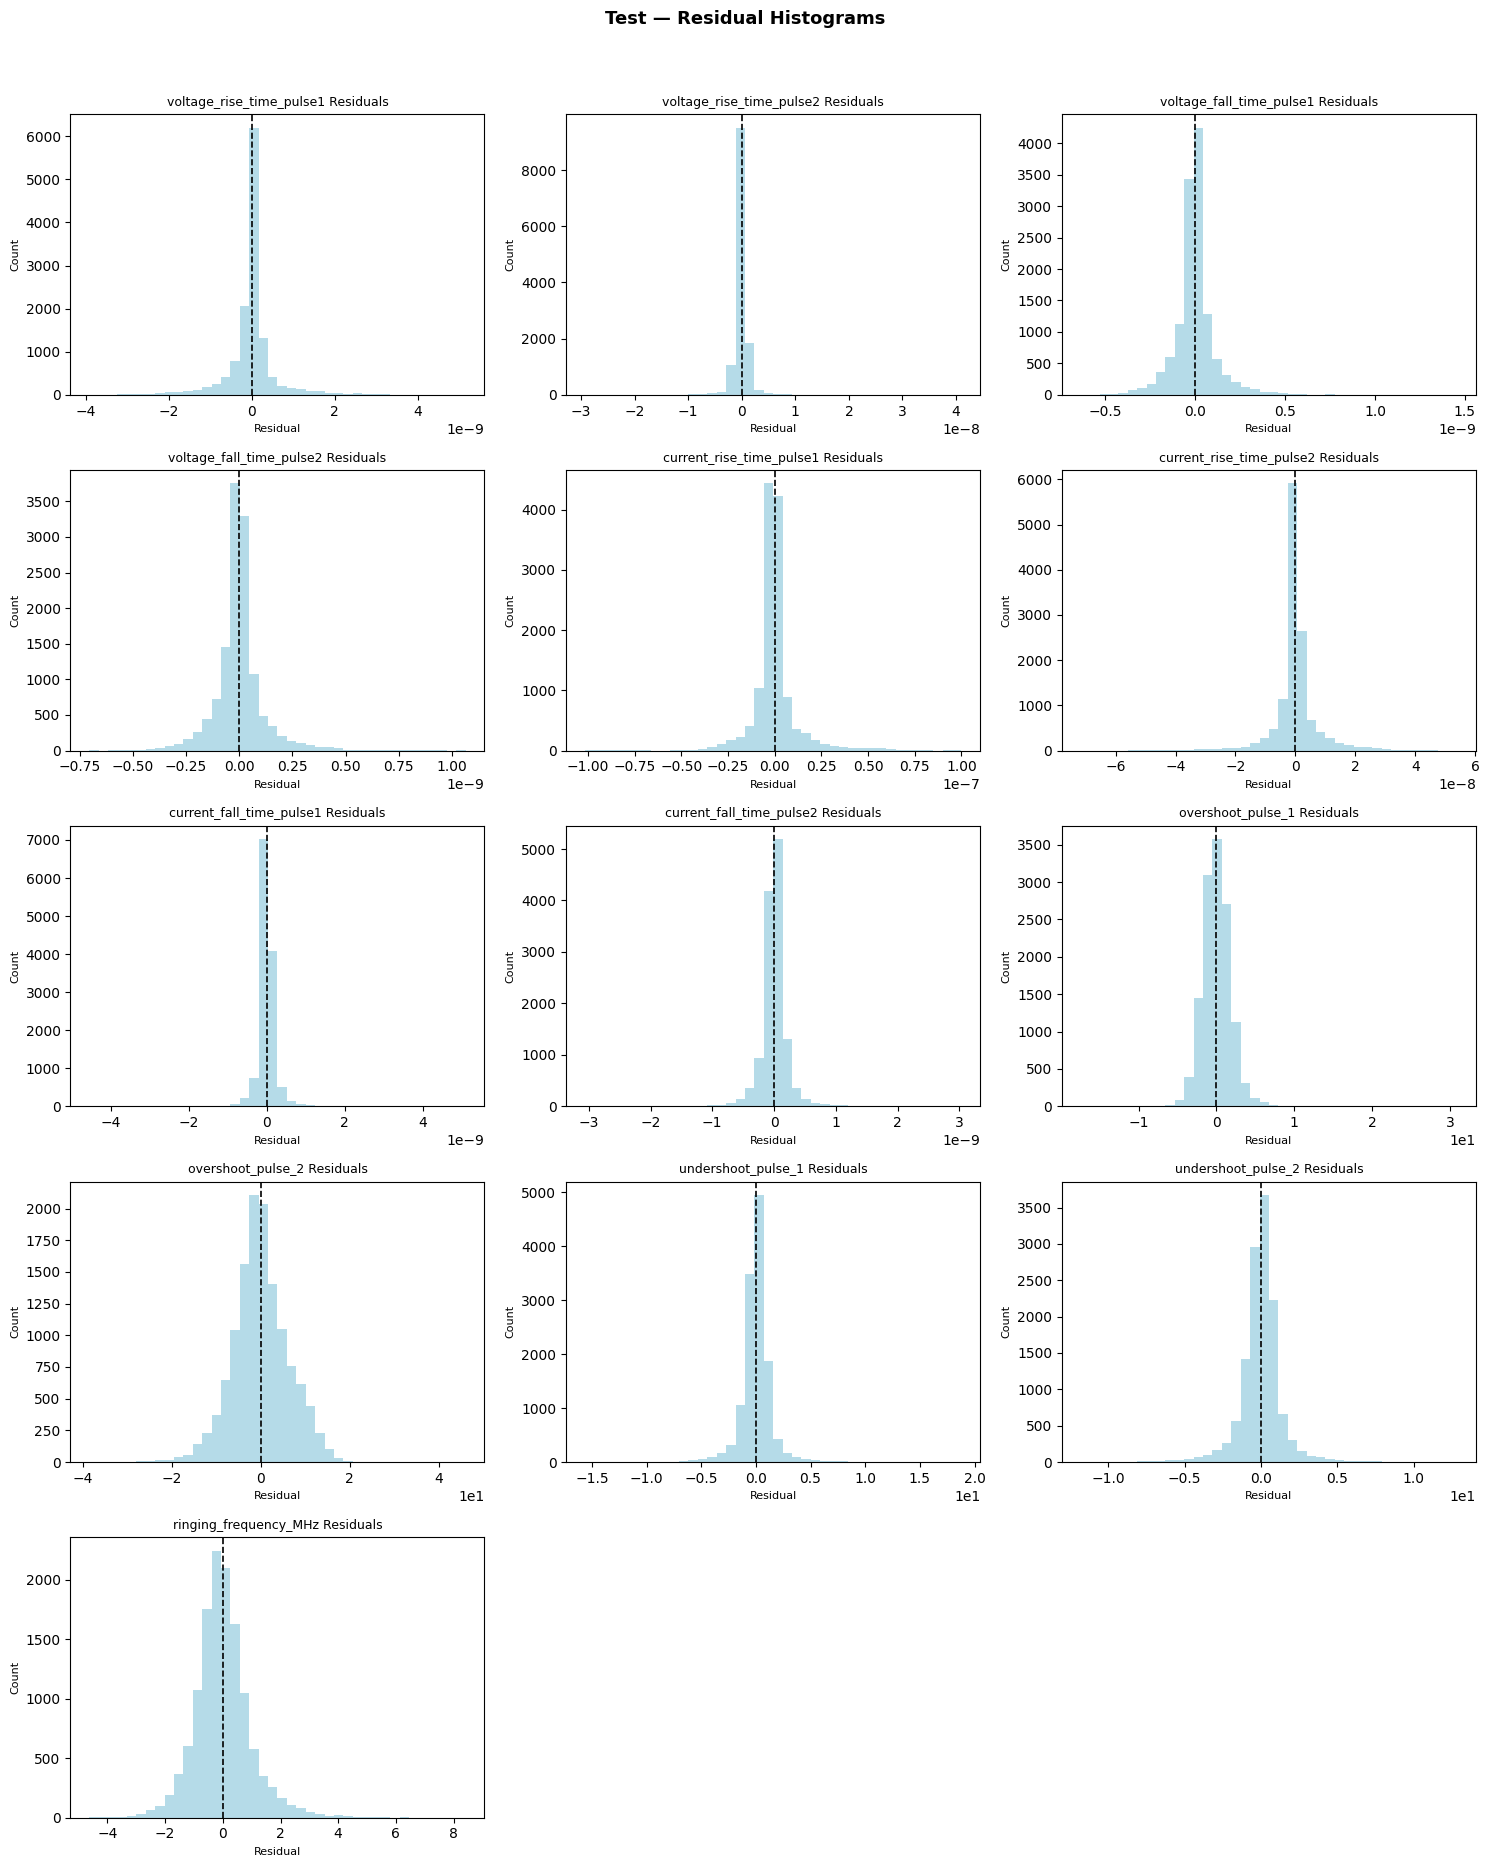

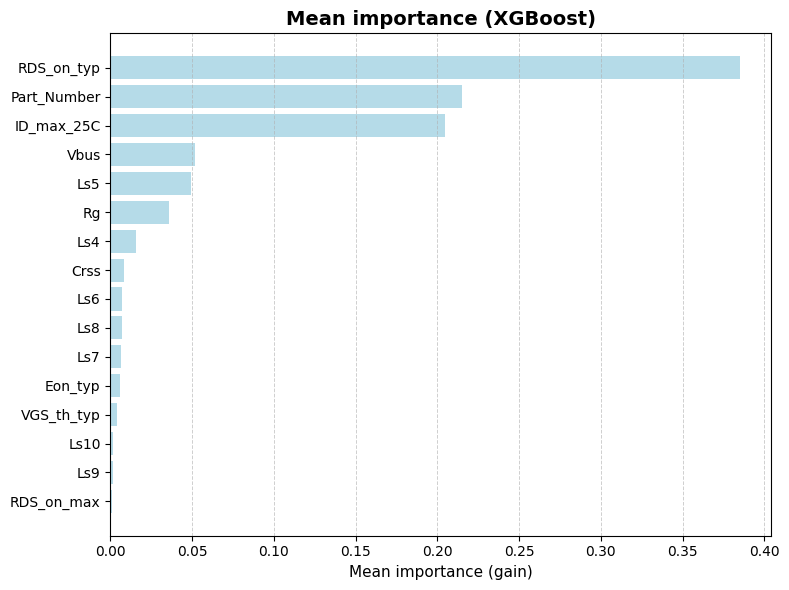


[SHAP] Explaining target: voltage_rise_time_pulse1


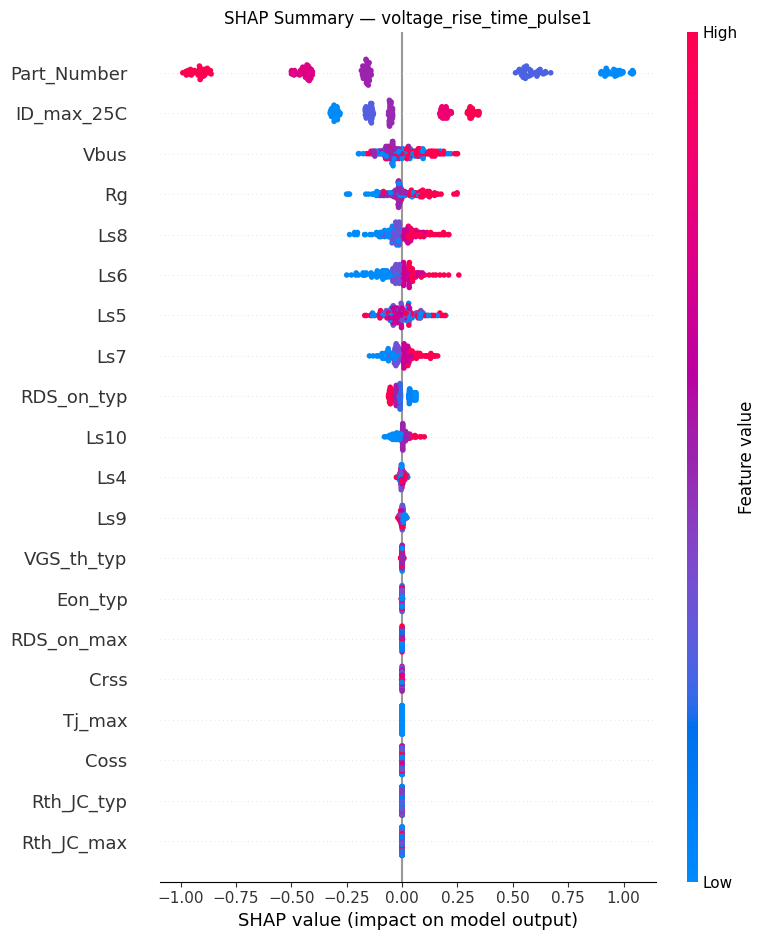

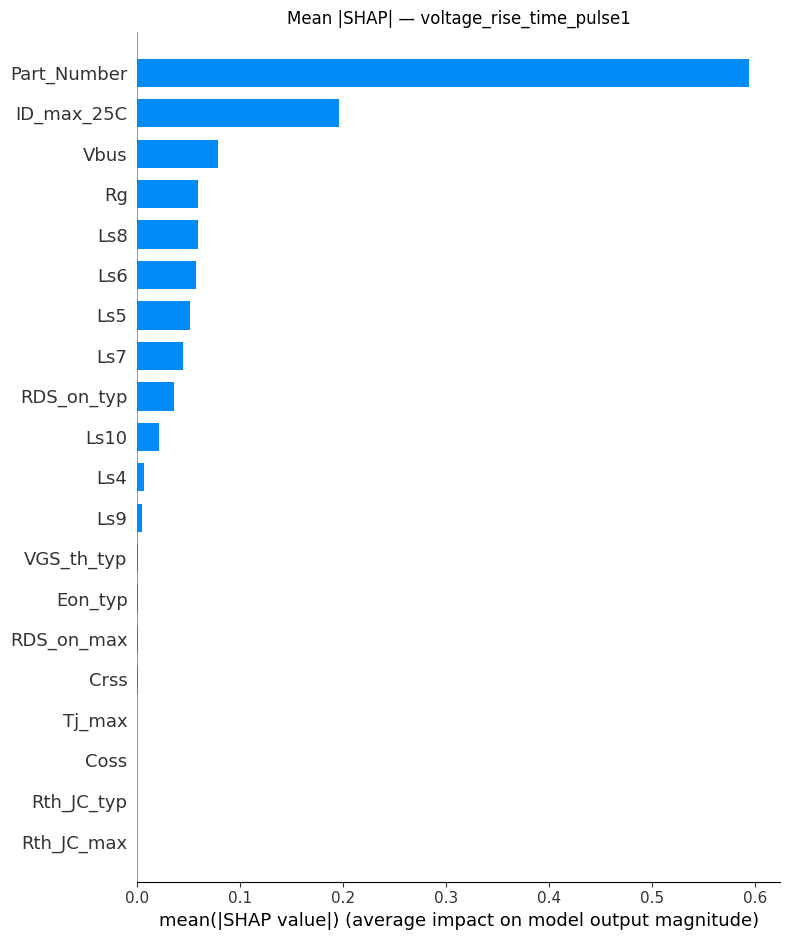


[SHAP] Explaining target: voltage_rise_time_pulse2


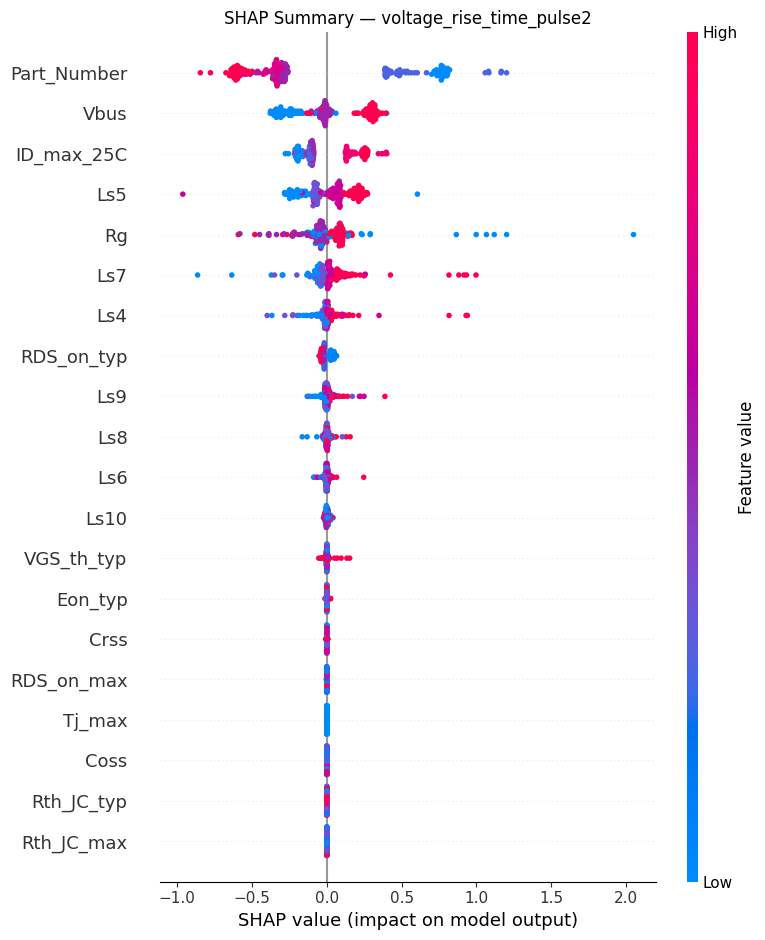

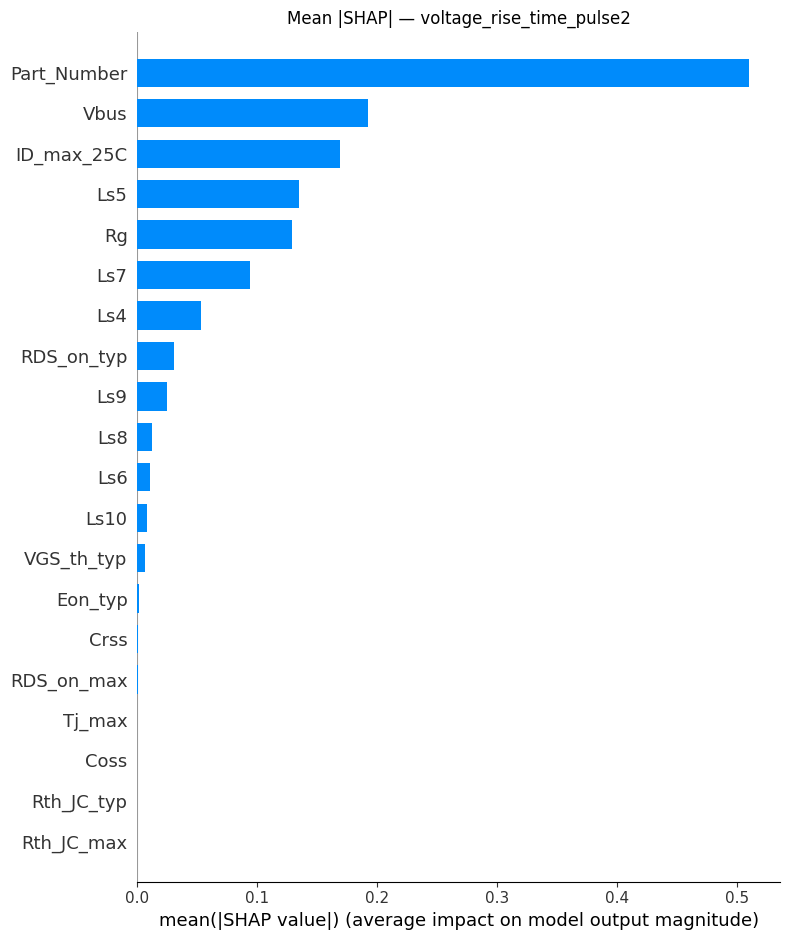


[SHAP] Explaining target: voltage_fall_time_pulse1


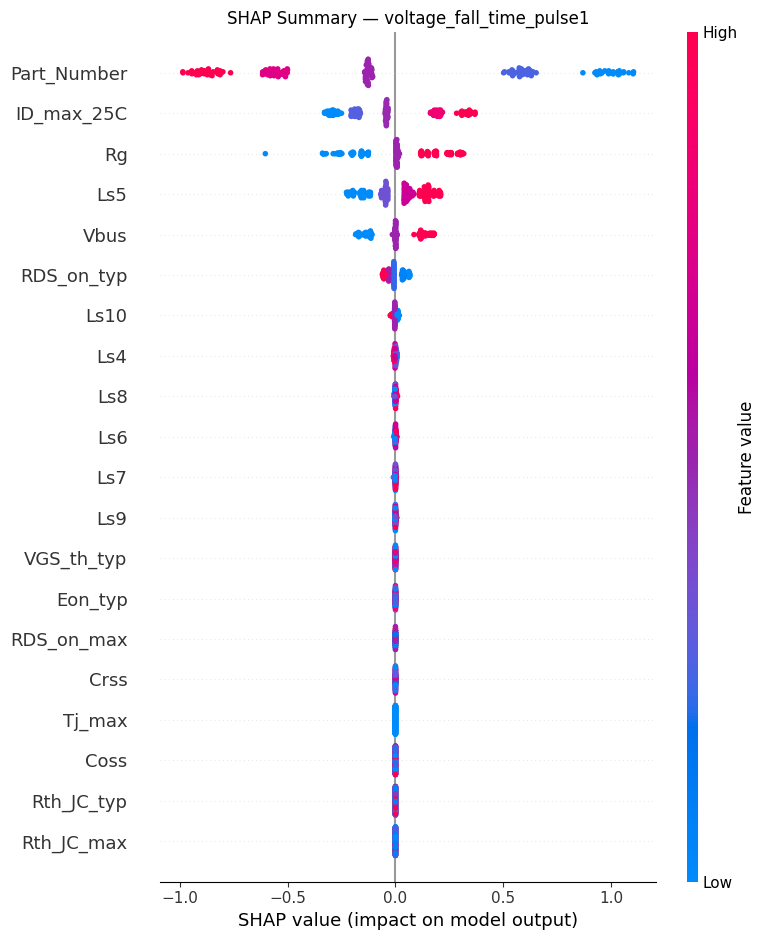

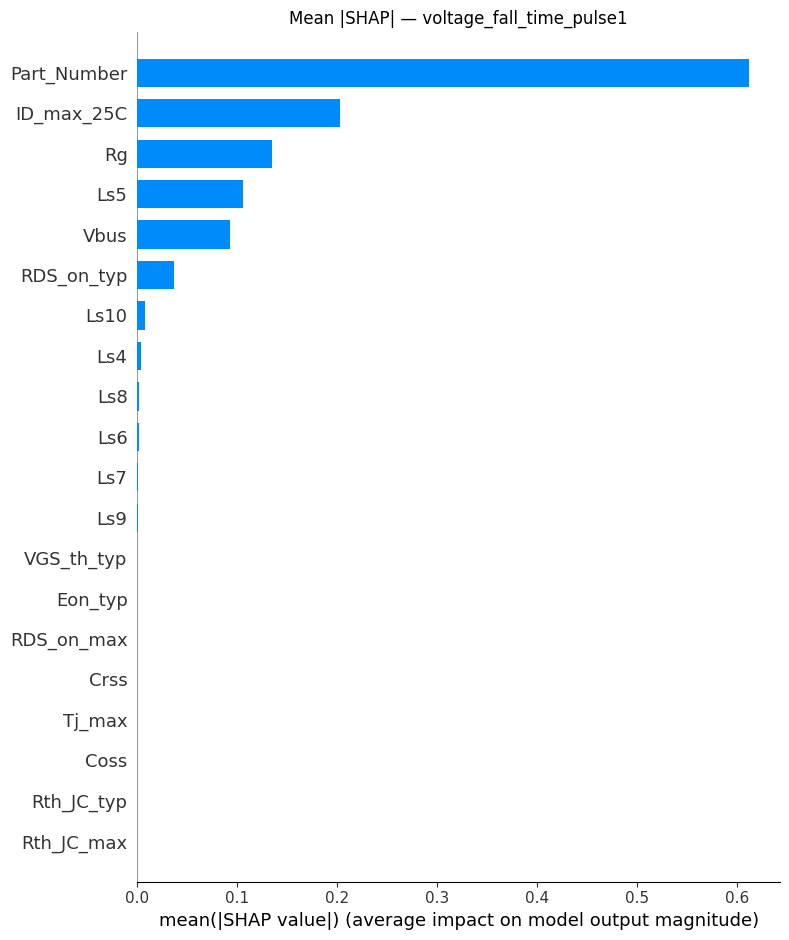


[SHAP] Explaining target: voltage_fall_time_pulse2


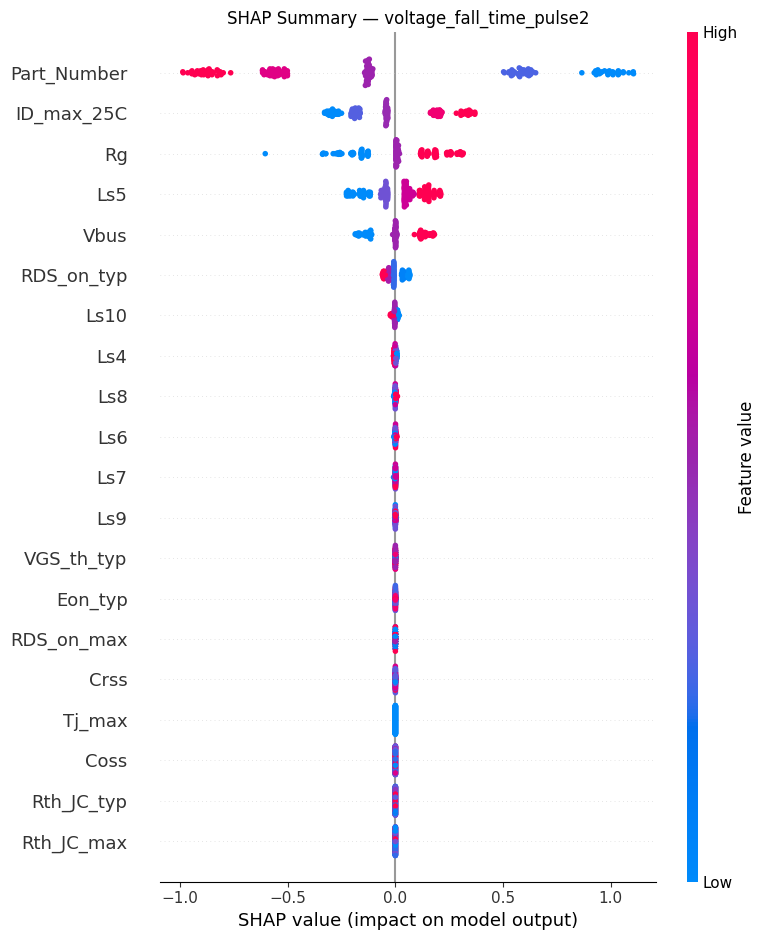

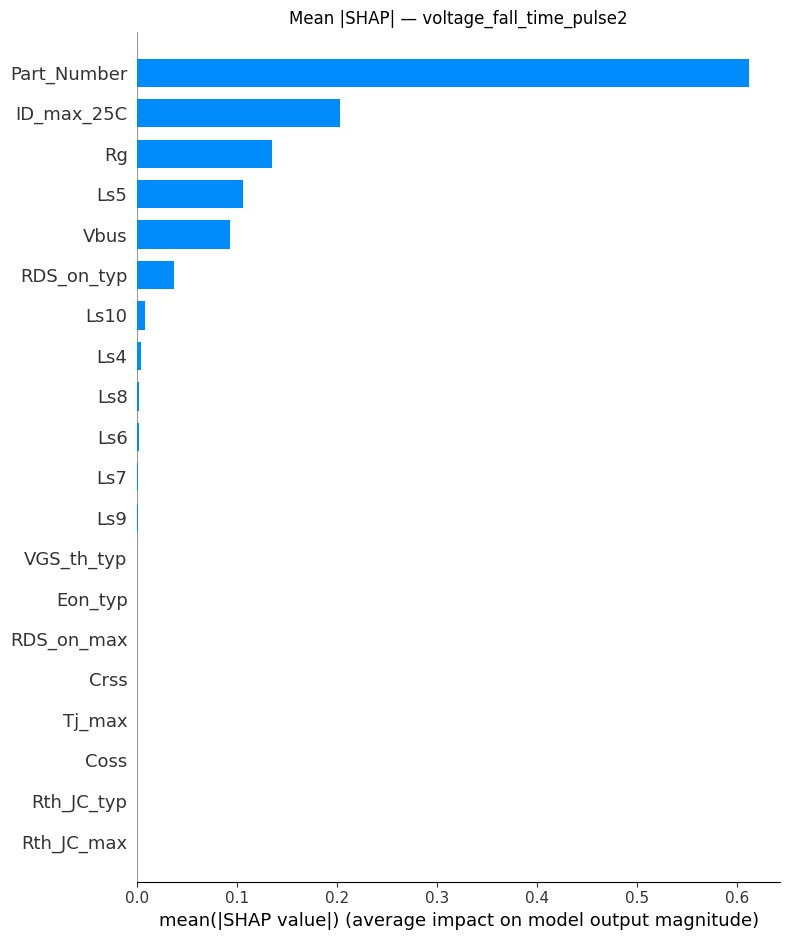


[SHAP] Explaining target: current_rise_time_pulse1


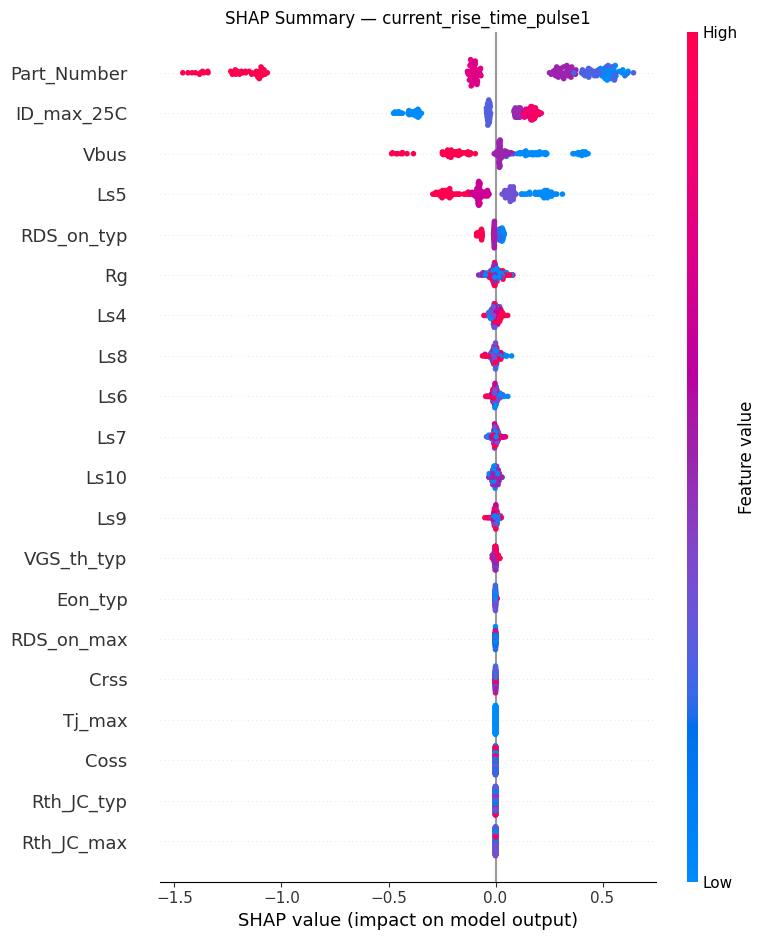

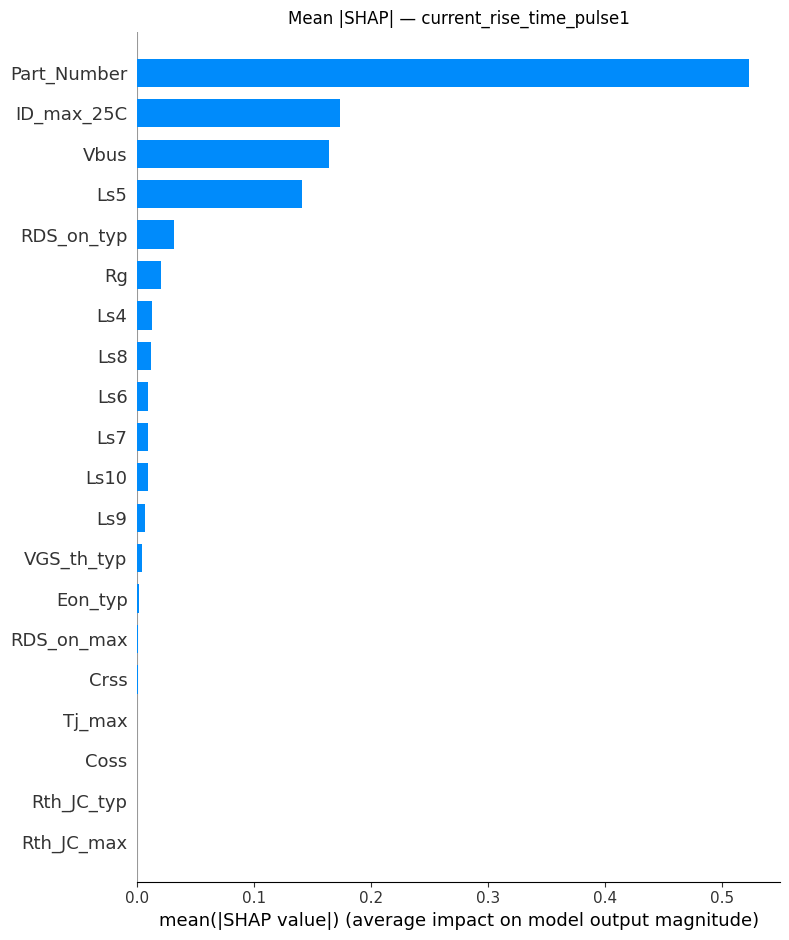


[SHAP] Explaining target: current_rise_time_pulse2


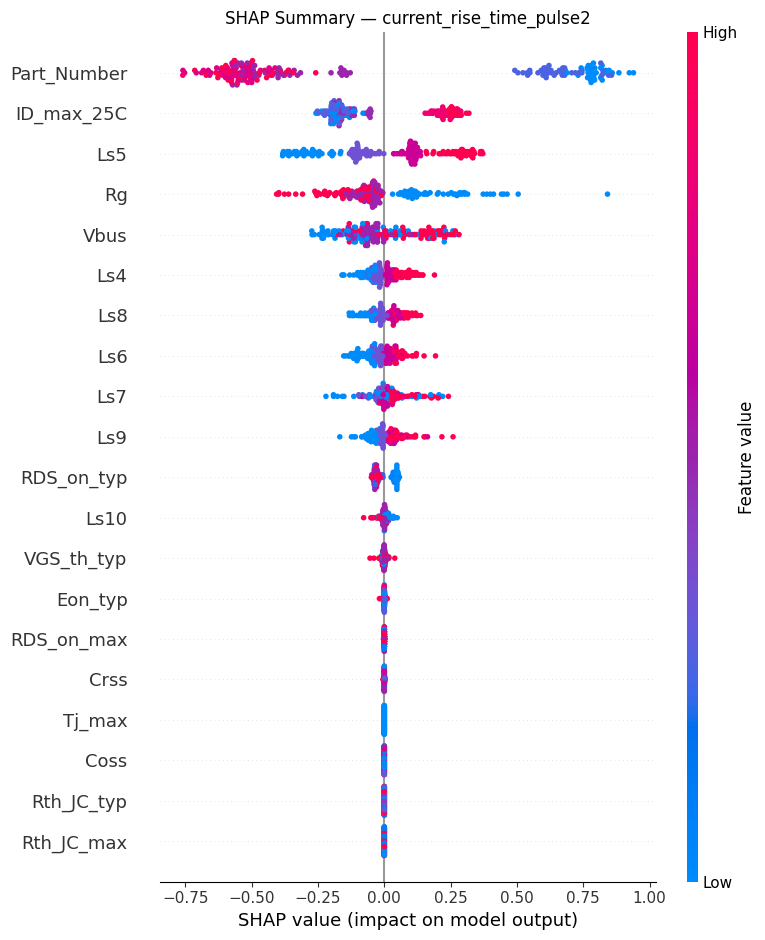

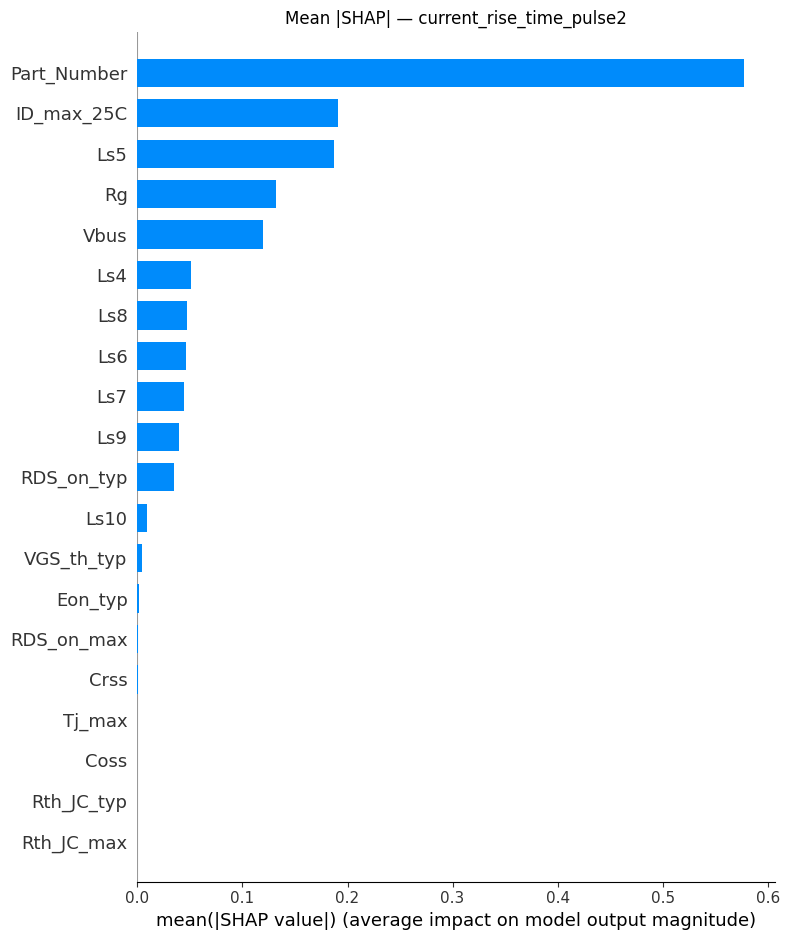


[SHAP] Explaining target: current_fall_time_pulse1


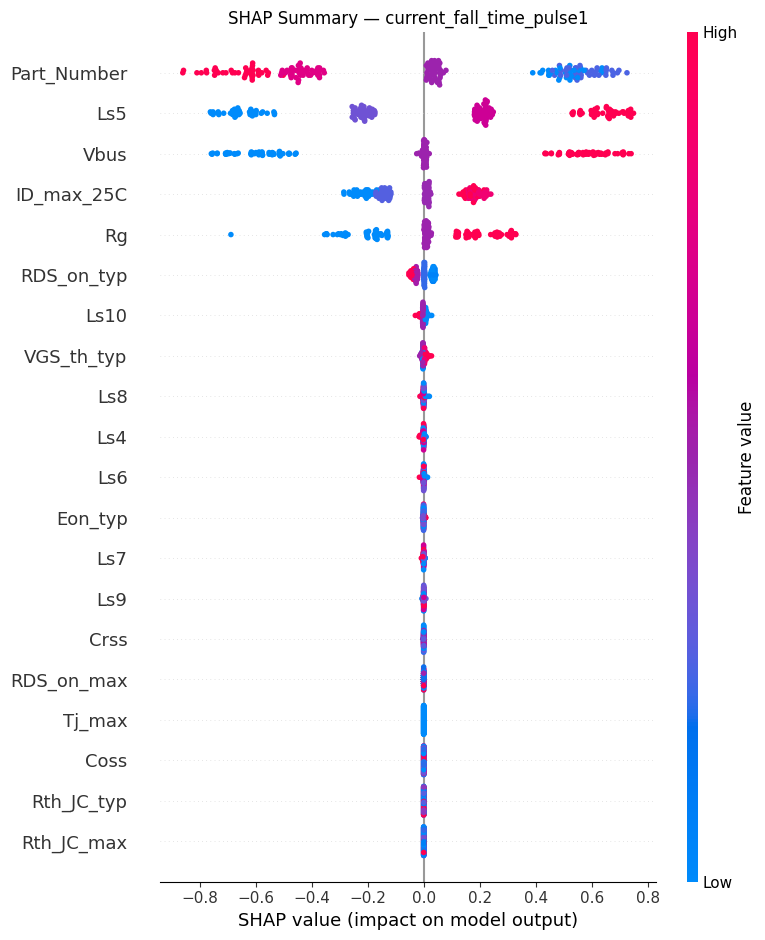

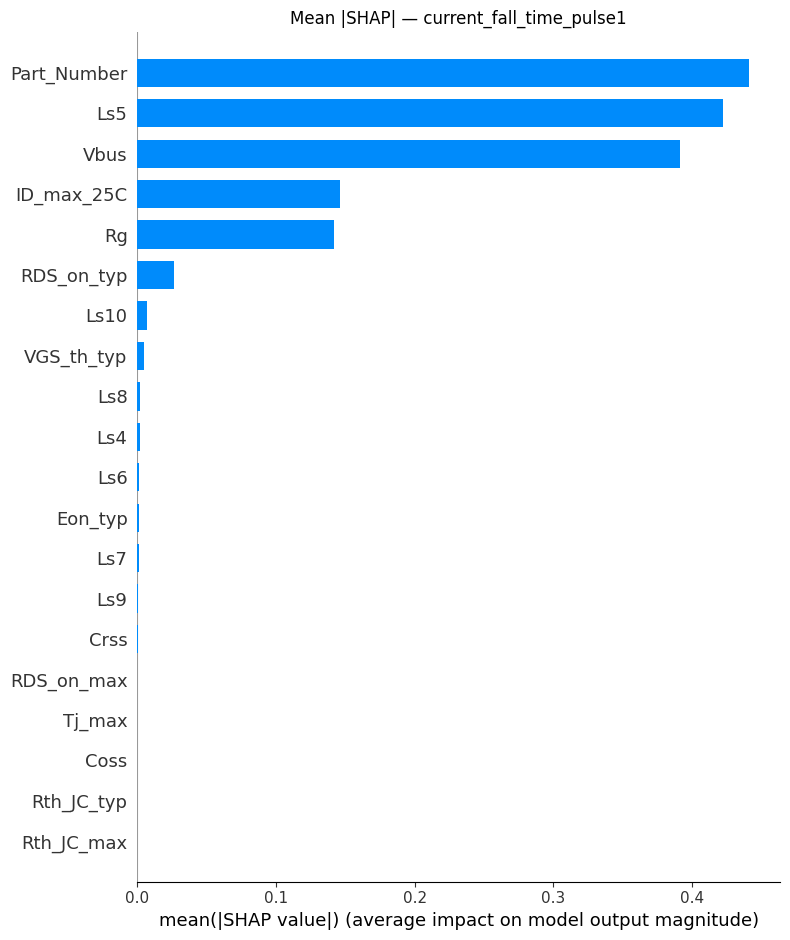


[SHAP] Explaining target: current_fall_time_pulse2


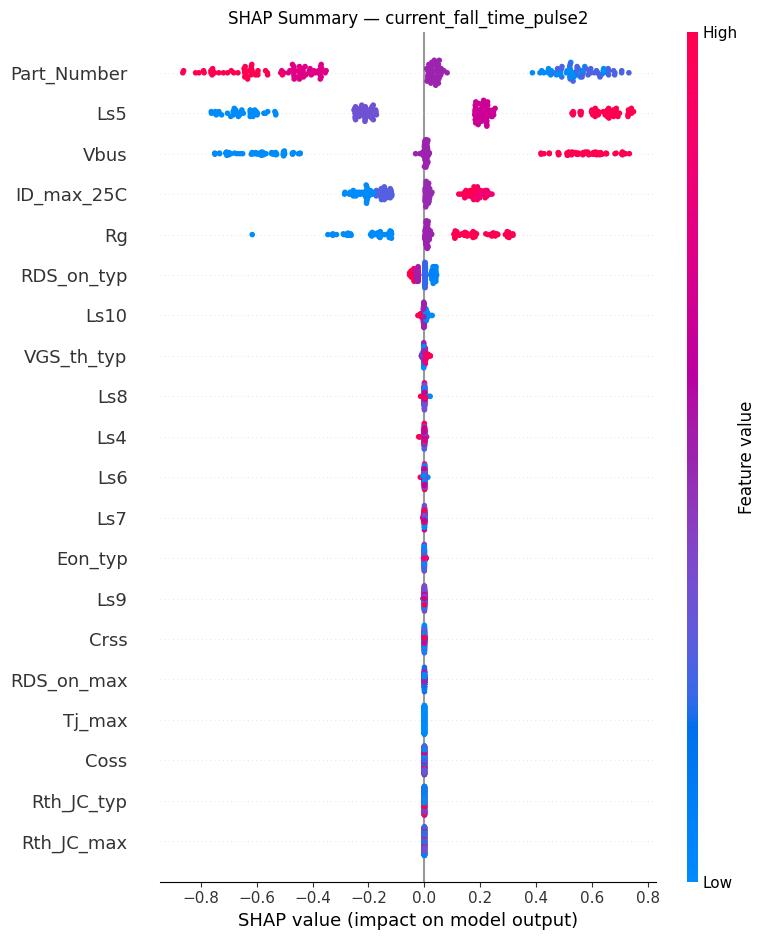

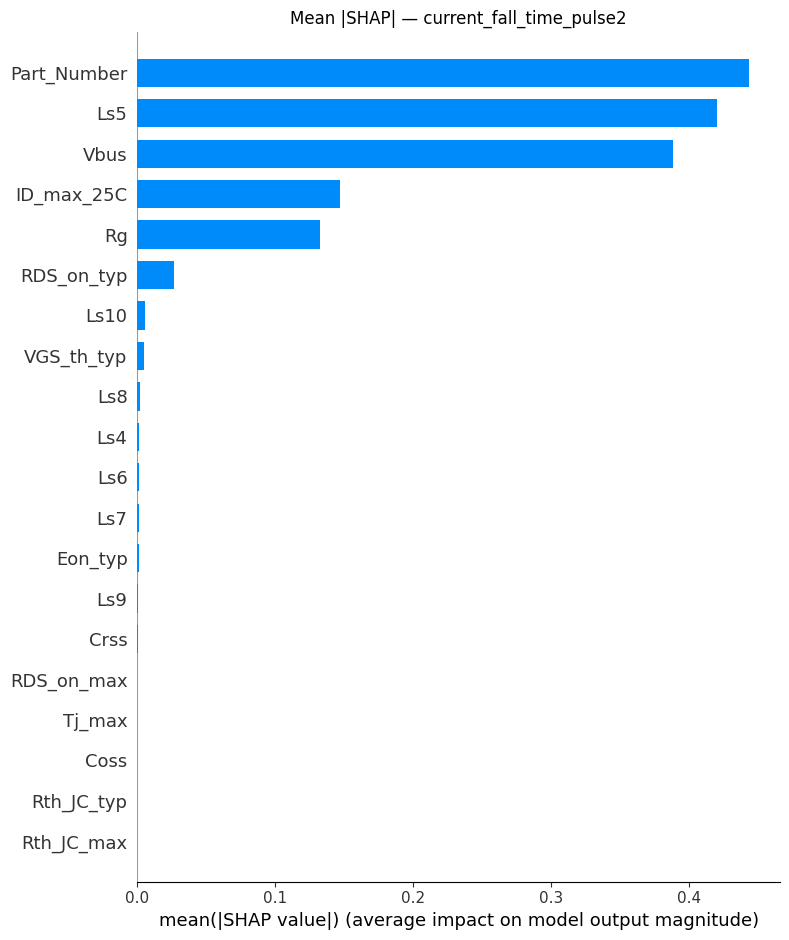


[SHAP] Explaining target: overshoot_pulse_1


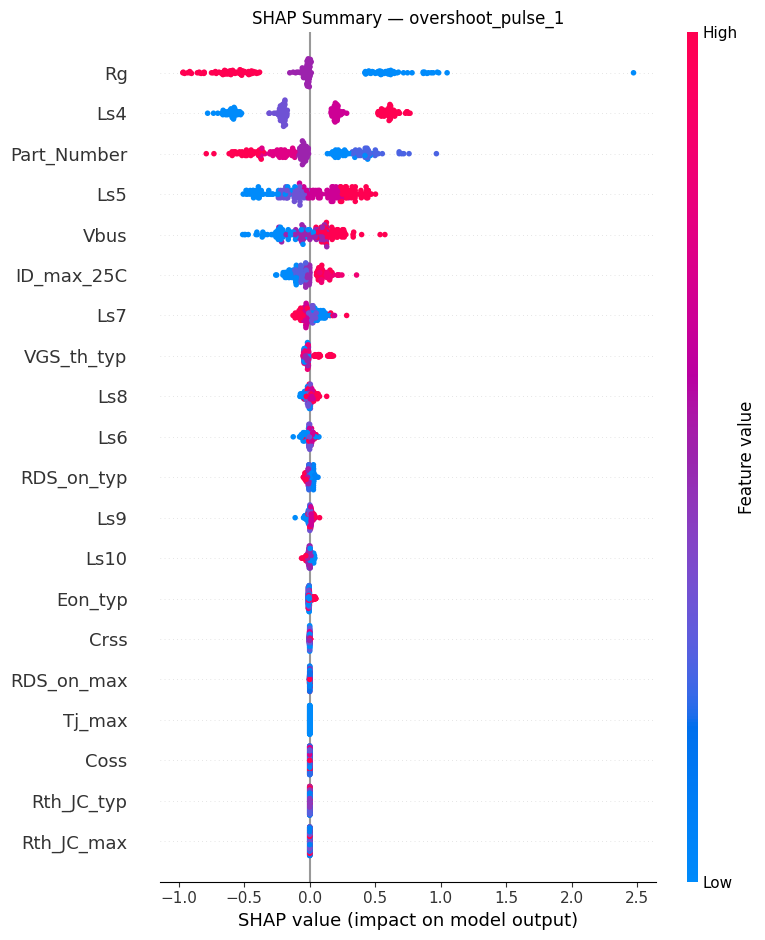

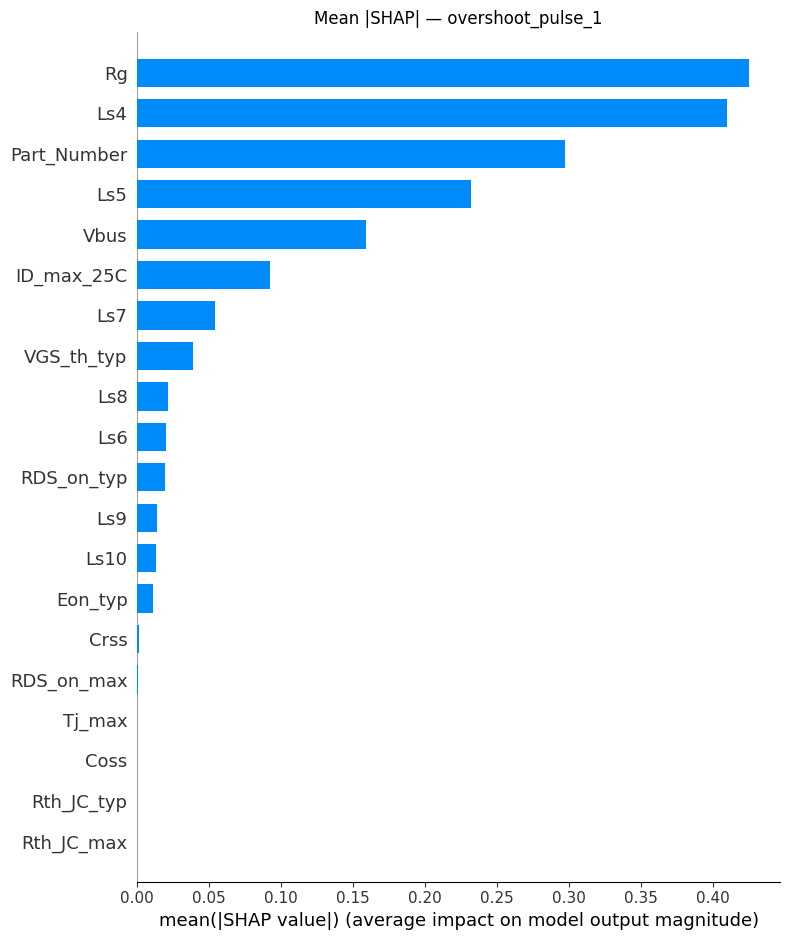


[SHAP] Explaining target: overshoot_pulse_2


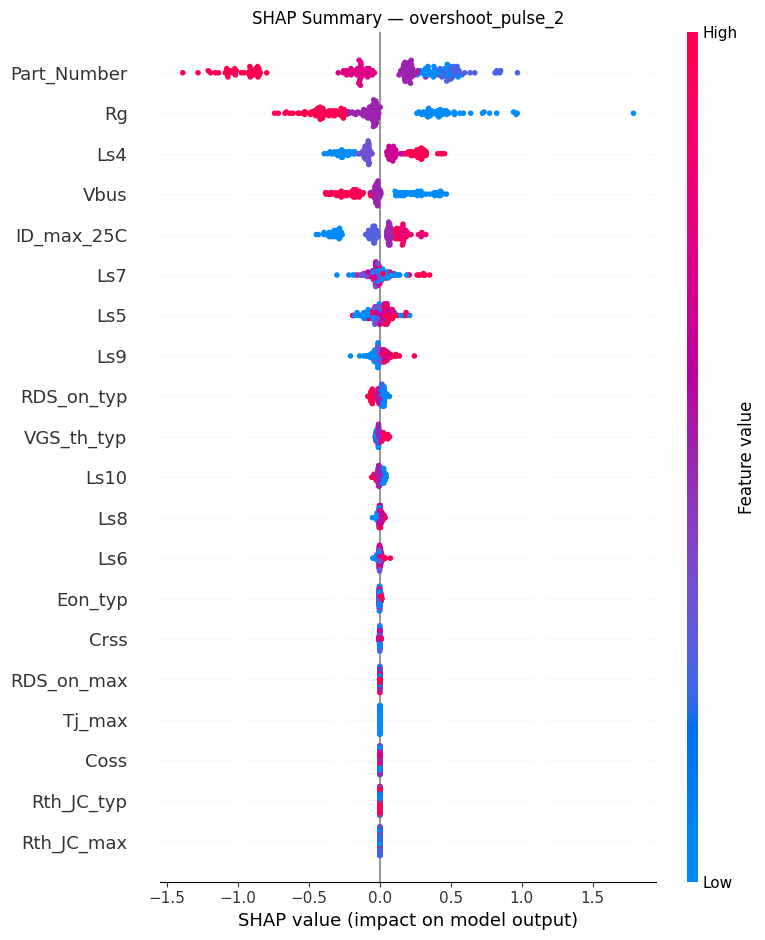

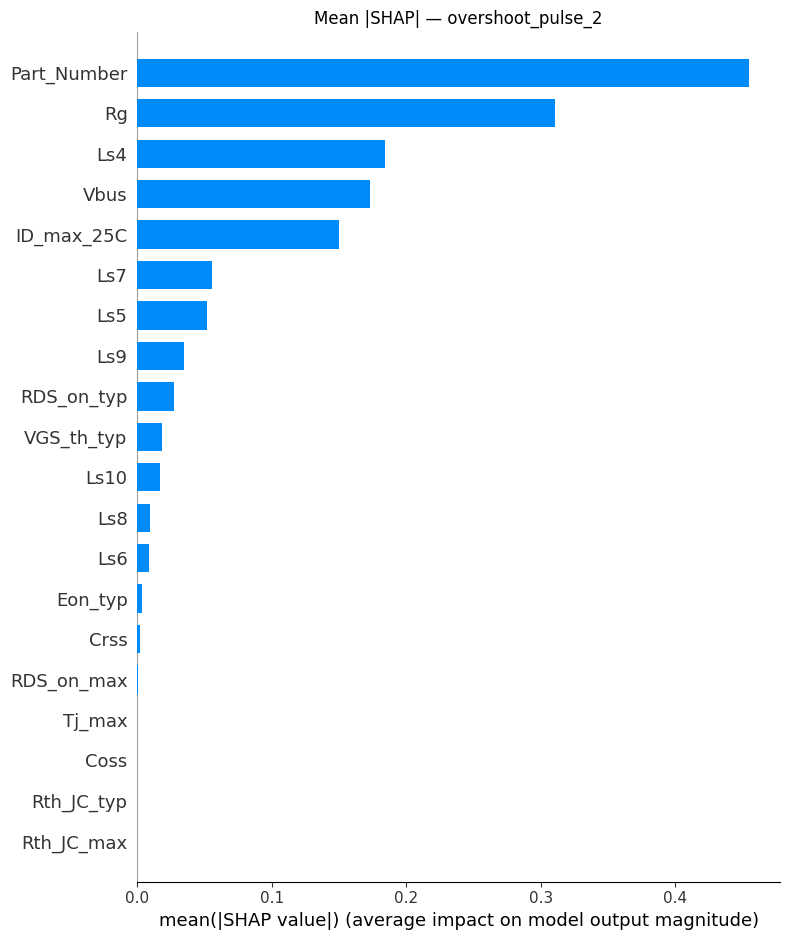


[SHAP] Explaining target: undershoot_pulse_1


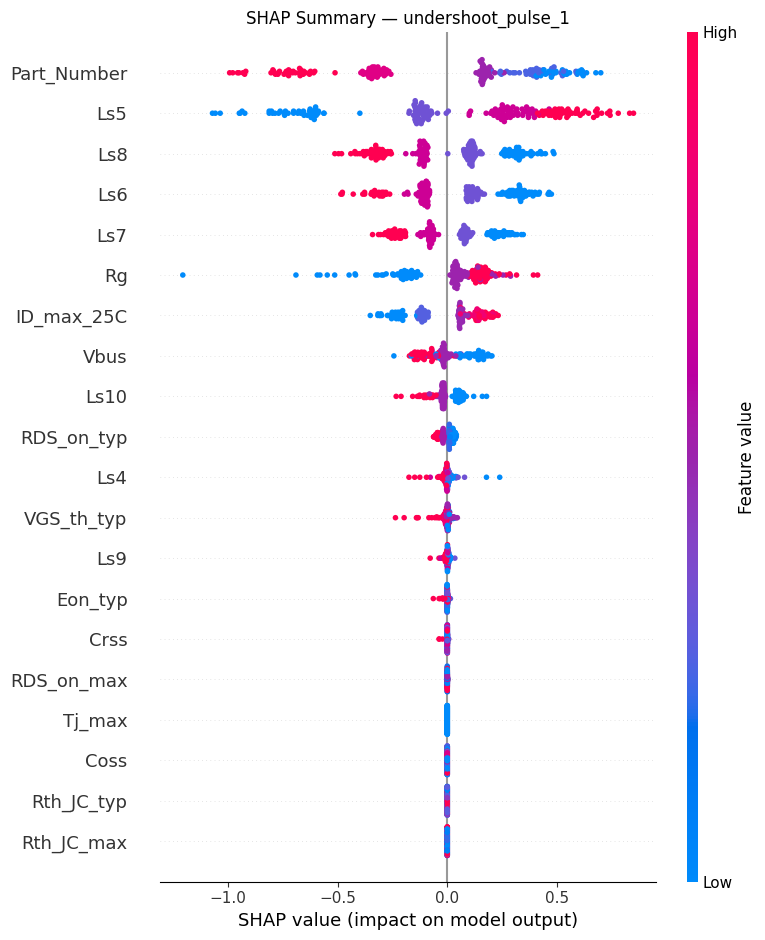

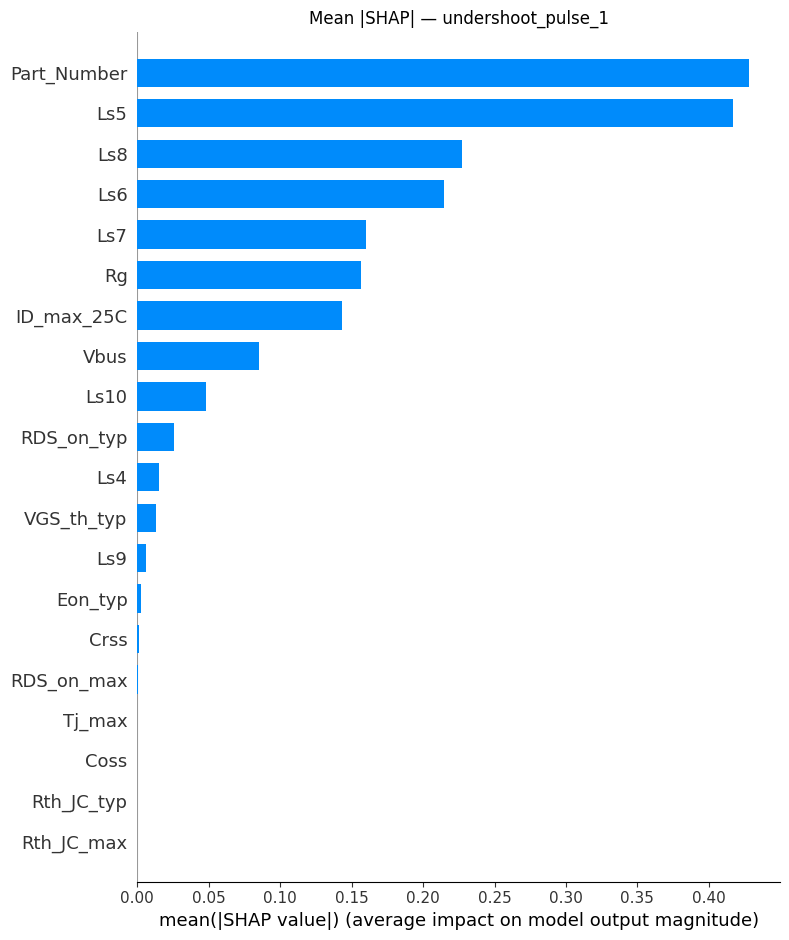


[SHAP] Explaining target: undershoot_pulse_2


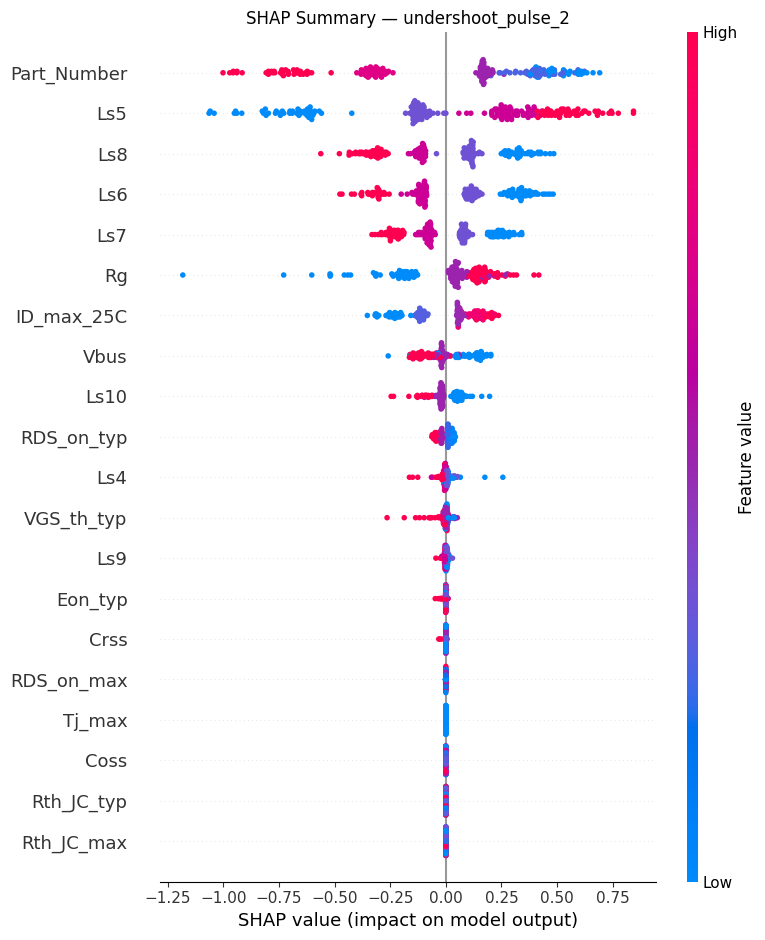

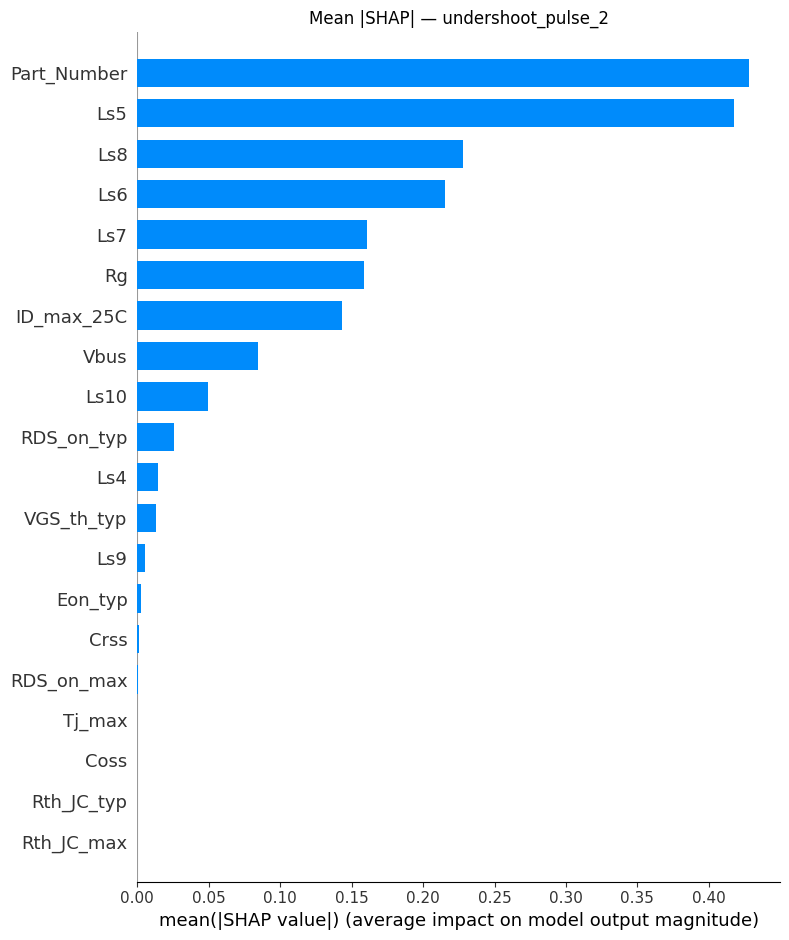


[SHAP] Explaining target: ringing_frequency_MHz


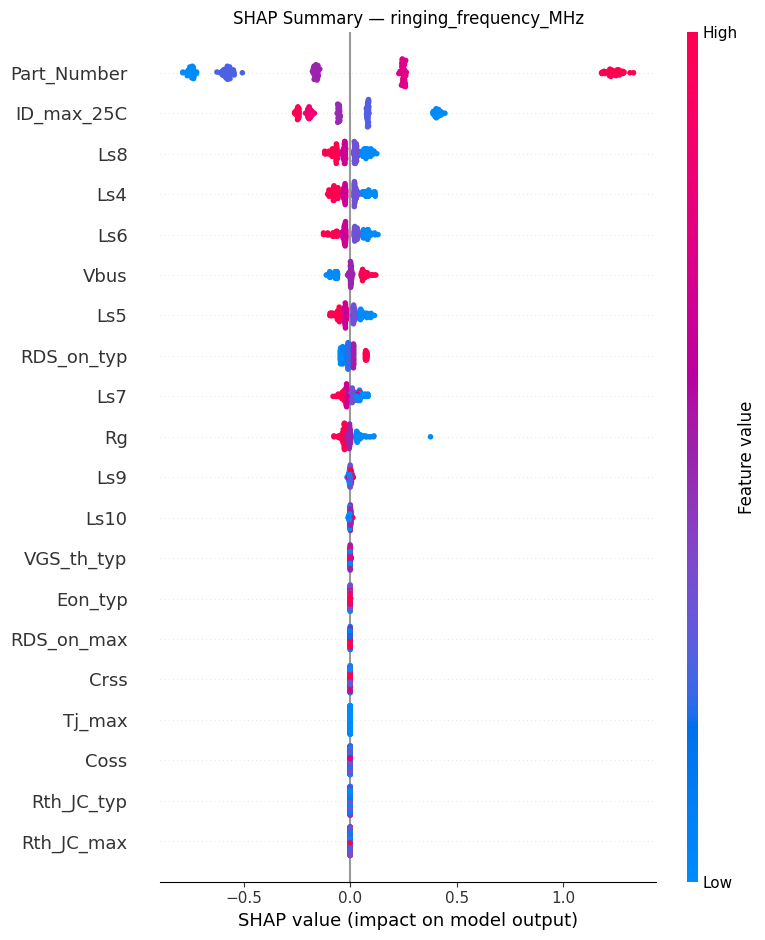

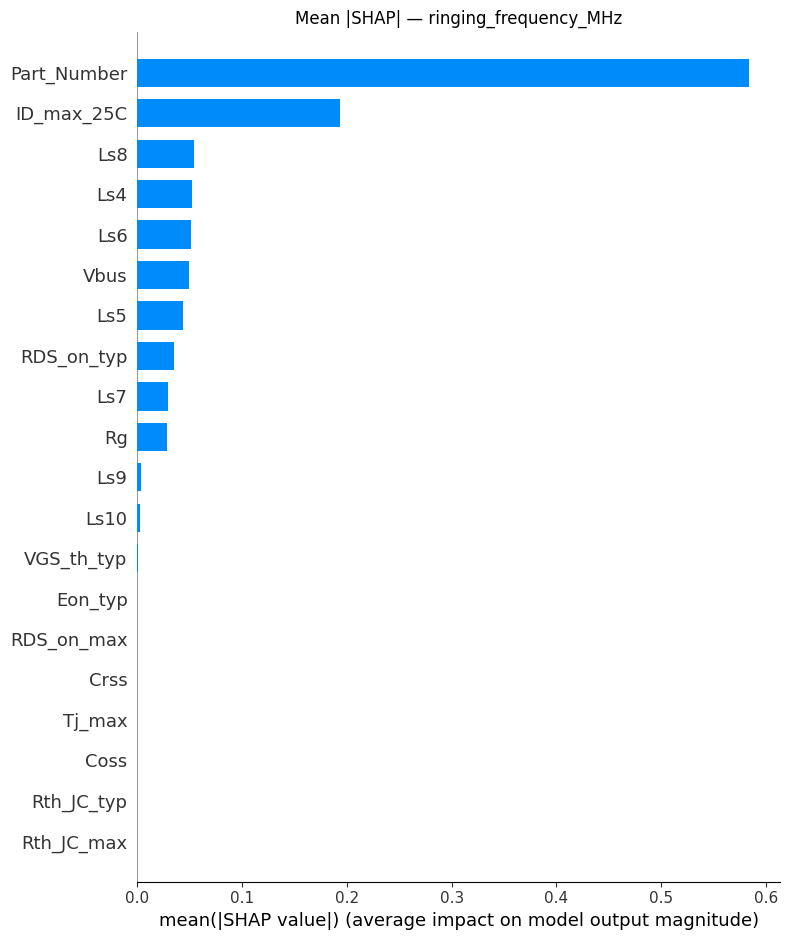

In [4]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor

from xgboost import XGBRegressor

# ----------------------------- Config -----------------------------
TRAIN_FILE    = r"C:\Users\pc\Desktop\THESIS_DISTINCTION_THRISHA_RAJKUMAR\merged_train_5_MOSFETs.csv"
RANDOM_STATE  = 42

FAST_FRACTION = 0.25     # balanced FAST sampling per (Vbus..Ls11) combo; set 1.0 for full run
GRID_COLS     = 3        # columns in grid-style plots
TOP_K_FEATURES = 16      # top-N features in importance bar plot
RUN_SHAP      = True     # set False to skip SHAP (faster)
# ------------------------------------------------------------------

# 13 multi-output targets (switching-transient surrogates)
TARGETS = [
    'voltage_rise_time_pulse1','voltage_rise_time_pulse2',
    'voltage_fall_time_pulse1','voltage_fall_time_pulse2',
    'current_rise_time_pulse1','current_rise_time_pulse2',
    'current_fall_time_pulse1','current_fall_time_pulse2',
    'overshoot_pulse_1','overshoot_pulse_2',
    'undershoot_pulse_1','undershoot_pulse_2',
    'ringing_frequency_MHz'
]

# Columns defining each simulation combo for balanced subsampling
COMBO_COLS = ["Vbus","Rg","Ls4","Ls5","Ls6","Ls7","Ls8","Ls9","Ls10","Ls11"]


# ==================================================================
# 1) Data helpers
# ==================================================================
def label_encode_part(df: pd.DataFrame) -> pd.DataFrame:
    """
    Encode 'Part_Number' as integer labels (tree models handle it fine).
    Using LabelEncoder keeps a single numeric column (faster than OHE).
    """
    if "Part_Number" in df.columns:
        enc = LabelEncoder()
        df["Part_Number"] = enc.fit_transform(df["Part_Number"].astype(str))
    return df

def balanced_sample(df: pd.DataFrame, cols, frac=0.25, seed=42) -> pd.DataFrame:
    """
    Take the same fraction of rows inside each unique combo (Vbus..Ls11).
    This preserves distribution across operating conditions while reducing size.
    """
    if frac >= 1.0:
        return df.reset_index(drop=True)
    rng = np.random.default_rng(seed)
    parts = []
    # groupby(..., dropna=False) preserves rows where any of the combo cols may have NaN
    for _, g in df.groupby(cols, dropna=False, sort=False):
        n = max(1, int(round(frac * len(g))))
        n = min(n, len(g))
        idx = rng.choice(g.index.to_numpy(), size=n, replace=False)
        parts.append(df.loc[idx])
    return pd.concat(parts, axis=0).sort_index().reset_index(drop=True)

def split_70_15_15(X, y, seed=42):
    """Return X_train, X_val, X_test, y_train, y_val, y_test with a 70/15/15 proportion."""
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.30, random_state=seed, shuffle=True)
    X_va, X_te, y_va, y_te   = train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=seed, shuffle=True)
    return X_tr, X_va, X_te, y_tr, y_va, y_te


# ==================================================================
# 2) Model + metrics
# ==================================================================
def make_xgb(seed=42) -> XGBRegressor:
    """
    Sensible XGB defaults for tabular regression (hist grower for speed).
    Feel free to tune (num_leaves via max_depth, reg_lambda, subsample, etc.).
    """
    return XGBRegressor(
        n_estimators=400,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        tree_method="hist",   # fast histogram grower
        n_jobs=-1,
        random_state=seed,
    )

def train_multioutput(X_tr, y_tr_s):
    """
    Train one XGBRegressor per target using MultiOutputRegressor.
    We scale outputs (y) only — inputs remain in physical units.
    """
    model = MultiOutputRegressor(make_xgb(RANDOM_STATE), n_jobs=-1)
    t0 = time.time()
    model.fit(X_tr, y_tr_s)
    train_time = time.time() - t0
    return model, train_time

def predict(model, X):
    """Predict and report latency (ms/sample)."""
    t0 = time.time()
    y_pred_s = model.predict(X)
    ms = (time.time() - t0) / max(1, len(X)) * 1000.0
    return y_pred_s, ms

def metrics_table(y_true, y_pred):
    """
    Compute per-target metrics (R2, RMSE, MAE) and overall averages.
    """
    rows = []
    for i, t in enumerate(TARGETS):
        yt, yp = y_true[:, i], y_pred[:, i]
        rows.append([t,
                     r2_score(yt, yp),
                     np.sqrt(mean_squared_error(yt, yp)),
                     mean_absolute_error(yt, yp)])
    per_target = pd.DataFrame(rows, columns=["Target", "R2", "RMSE", "MAE"])
    overall = {
        "R2_avg":   r2_score(y_true, y_pred, multioutput="uniform_average"),
        "RMSE_avg": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE_avg":  mean_absolute_error(y_true, y_pred),
    }
    return per_target, overall


# ==================================================================
# 3) Visualizations
# ==================================================================
def plot_r2_bars(val_df: pd.DataFrame, test_df: pd.DataFrame):
    """Grouped R² bars (Validation vs Test) with your light-pink / light-blue palette."""
    targets = val_df["Target"].tolist()
    x = np.arange(len(targets))
    width = 0.35

    fig, ax = plt.subplots(figsize=(max(10, 0.6*len(targets)), 5))
    ax.bar(x - width/2, val_df["R2"].values,  width, label="Validation", color="#ffb6c1", alpha=0.8)
    ax.bar(x + width/2, test_df["R2"].values, width, label="Test",       color="#add8e6", alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(targets, rotation=45, ha="right", fontsize=9)
    ax.set_ylabel("R²", fontsize=11)
    ax.set_title("Per-target R²: Validation vs Test", fontsize=13, weight="bold")
    ax.set_ylim(0.6, 1.0)
    ax.grid(axis='y', linestyle='--', alpha=0.6, linewidth=0.7)
    ax.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_test_scatter(y_true, y_pred, target_names, n_cols=GRID_COLS):
    """Test: Actual vs Predicted per target with ideal y=x reference."""
    n_targets = len(target_names)
    n_rows = int(np.ceil(n_targets / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.8*n_cols, 3*n_rows))
    axes = axes.flatten()

    for i, t in enumerate(target_names):
        ax = axes[i]
        ax.scatter(y_true[:, i], y_pred[:, i], s=10, alpha=0.6,
                   color="darkblue", edgecolors='none')
        mn = min(y_true[:, i].min(), y_pred[:, i].min())
        mx = max(y_true[:, i].max(), y_pred[:, i].max())
        ax.plot([mn, mx], [mn, mx], '--', lw=1.2, color="red", alpha=0.8)
        ax.set_title(t, fontsize=9, weight="bold")
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
        ax.set_xlabel("Actual", fontsize=8)
        ax.set_ylabel("Predicted", fontsize=8)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("Test — Actual vs Predicted", fontsize=14, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_residual_histograms(y_true, y_pred, target_names, n_cols=GRID_COLS):
    """Residual histograms on Test: symmetry around 0 indicates low bias."""
    res = y_true - y_pred
    n_targets = len(target_names)
    n_rows = int(np.ceil(n_targets / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 3.8*n_rows))
    axes = axes.flatten()

    for i, t in enumerate(target_names):
        ax = axes[i]
        ax.hist(res[:, i], bins=40, color="#add8e6", alpha=0.9)
        ax.axvline(0.0, linestyle='--', linewidth=1.2, color="black")
        ax.set_title(f"{t} Residuals", fontsize=9)
        ax.set_xlabel("Residual", fontsize=8)
        ax.set_ylabel("Count", fontsize=8)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        ax.grid(False)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("Test — Residual Histograms", fontsize=13, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_mean_importance_xgb(multi_model, feature_names, top_k=TOP_K_FEATURES):
    """
    Mean feature importance across targets.
    Uses XGBoost's feature_importances_ (gain by default for sklearn wrapper).
    """
    importances = []
    for est in multi_model.estimators_:
        importances.append(est.feature_importances_)
    importances = np.array(importances)                   # (n_targets, n_features)
    mean_imp = importances.mean(axis=0)

    imp_df = pd.DataFrame({"feature": feature_names, "importance": mean_imp})
    imp_df = imp_df.sort_values("importance", ascending=False).head(top_k).iloc[::-1]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(imp_df["feature"], imp_df["importance"], color="#add8e6", alpha=0.9)
    ax.set_title("Mean importance (XGBoost)", fontsize=14, weight="bold")
    ax.set_xlabel("Mean importance (gain)", fontsize=11)
    ax.set_ylabel("")
    ax.grid(axis="x", linestyle="--", alpha=0.6, linewidth=0.7)
    plt.tight_layout()
    plt.show()


# ==================================================================
# 4) Main
# ==================================================================
def main():
    # A) Load data, drop rows with any NaNs (conservative), encode Part_Number
    df = pd.read_csv(TRAIN_FILE).dropna().reset_index(drop=True)
    df = label_encode_part(df)

    # B) Balanced FAST sample for iteration speed
    df_fast = balanced_sample(df, COMBO_COLS, frac=FAST_FRACTION, seed=RANDOM_STATE)
    print(f"[INFO] Using {len(df_fast)} rows (of {len(df)})")

    # C) Build feature/target matrices
    feature_cols = [c for c in df_fast.columns if c not in TARGETS]

    # Cast to float32 for speed/memory; trees don’t need scaling of X
    for c in feature_cols:
        df_fast[c] = df_fast[c].astype(np.float32)

    X = df_fast[feature_cols].to_numpy(dtype=np.float32)
    y = df_fast[TARGETS].to_numpy(dtype=np.float32)

    # D) Split
    X_tr, X_va, X_te, y_tr, y_va, y_te = split_70_15_15(X, y, seed=RANDOM_STATE)

    # E) Scale outputs ONLY (XGBoost is happy with raw input units)
    y_scaler = StandardScaler()
    y_tr_s = y_scaler.fit_transform(y_tr)
    y_va_s = y_scaler.transform(y_va)
    y_te_s = y_scaler.transform(y_te)

    # F) Train
    model, train_sec = train_multioutput(X_tr, y_tr_s)
    print(f"[INFO] Train time: {train_sec:.2f}s")

    # G) Predict (inverse-transform to physical units)
    y_va_pred_s, va_ms = predict(model, X_va)
    y_te_pred_s, te_ms = predict(model, X_te)
    y_va_pred = y_scaler.inverse_transform(y_va_pred_s)
    y_te_pred = y_scaler.inverse_transform(y_te_pred_s)

    # H) Metrics
    va_df, va_over = metrics_table(y_va, y_va_pred)
    te_df, te_over = metrics_table(y_te, y_te_pred)

    def fmt_row(df):
        return df.assign(
            R2=df.R2.map(lambda x: f"{x:.4f}"),
            RMSE=df.RMSE.map(lambda x: f"{x:.4e}"),
            MAE=df.MAE.map(lambda x: f"{x:.4e}")
        )

    print("\n=== Validation (per target) ===")
    print(fmt_row(va_df).to_string(index=False))
    print(pd.Series({k: (f"{v:.4f}" if "R2" in k else f"{v:.4e}") for k, v in va_over.items()}))

    print("\n=== Test (per target) ===")
    print(fmt_row(te_df).to_string(index=False))
    print(pd.Series({k: (f"{v:.4f}" if "R2" in k else f"{v:.4e}") for k, v in te_over.items()}))
    print(f"\nLatency: Val {va_ms:.3f} ms/sample | Test {te_ms:.3f} ms/sample")

    # I) Plots
    plot_r2_bars(va_df, te_df)
    plot_test_scatter(y_te, y_te_pred, TARGETS, n_cols=GRID_COLS)
    plot_residual_histograms(y_te, y_te_pred, TARGETS, n_cols=GRID_COLS)
    plot_mean_importance_xgb(model, feature_cols, TOP_K_FEATURES)

    # J) Optional SHAP analysis (summary + bar) per target on a small sample
    if RUN_SHAP:
        import shap
        shap.initjs()  # enable JS rendering in notebooks; harmless in pure .py

        # Use a small background + explanation sample for speed
        rng = np.random.default_rng(RANDOM_STATE)
        bg_idx  = rng.choice(X_tr.shape[0], size=min(200, X_tr.shape[0]), replace=False)
        exp_idx = rng.choice(X_va.shape[0], size=min(200, X_va.shape[0]), replace=False)
        background = X_tr[bg_idx]
        sample     = X_va[exp_idx]
        sample_df  = pd.DataFrame(sample, columns=feature_cols)

        for i, target_name in enumerate(TARGETS):
            print(f"\n[SHAP] Explaining target: {target_name}")
            single_model = model.estimators_[i]

            # TreeExplainer is fast and exact for tree ensembles
            explainer = shap.TreeExplainer(single_model)
            shap_values = explainer.shap_values(sample, check_additivity=False)

            # Summary (beeswarm)
            plt.title(f"SHAP Summary — {target_name}")
            shap.summary_plot(shap_values, sample_df, show=False)
            plt.tight_layout()
            plt.show()

            # Mean |SHAP| bar plot
            plt.title(f"Mean |SHAP| — {target_name}")
            shap.summary_plot(shap_values, sample_df, plot_type="bar", show=False)
            plt.tight_layout()
            plt.show()


if __name__ == "__main__":
    # Basic guard: readable error if file path is wrong
    if not Path(TRAIN_FILE).exists():
        raise FileNotFoundError(f"TRAIN_FILE not found: {TRAIN_FILE}")
    main()
